# TSMAI sheet01 2025

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from itertools import combinations

In [2]:
class Data:
    """
    treating the data for task 1
    Parameters:
        path (str) : path for loading data
        skiprows (int) : skipping header rows default 1
    """
    
    def __init__(self, path: str, elements: list, **kwargs):
        self.path = path
        self.elements = elements
        self.raw = np.loadtxt(self.path,**kwargs).T

    def get_raw(self):
        return self.raw
    
    def get_index(self,indx):
        return self.raw[indx]
    
    def std_for_plot(self,indx: list):
        self.standardized = ( ( self.raw[indx].T - np.mean(self.raw[indx],axis=1) )/np.var(self.raw[indx],axis=1) ).T
        print(f"standardized array of the indexes created, shape : {np.shape(self.standardized)}")
        return self.standardized
    

    def calc_correlations(self, indx: list):
        pairs = list(combinations(indx,2))
        correlations = np.zeros(len(pairs)) # = len(indx)*(len(indx)-1)/2

        for i,pair in enumerate(pairs):
            correlations[i] = Correlation(self.raw[pair[0]],self.raw[pair[1]])

        return pairs, correlations
    
    def return_map(self, indx: int, length: int, title: str=None, cmap='viridis'):
        """
        Plot a return map (x_n vs x_{n+1}) with fading trail effect using only numpy and pyplot.
        
        Parameters:
            x (array): Input time series
            color (str): Color of the trajectory (matplotlib color)
            alpha_start (float): Starting opacity (0-1)
            alpha_end (float): Ending opacity (0-1)
        """
        x = self.standardized[indx-1,:length]

        # Create return map coordinates
        x_n = x[:-1]
        x_n1 = x[1:]
        n_points = len(x_n)
        
        # Create figure
        plt.figure(figsize=(8, 8))
        
        # Create color values (0 to 1 along the trajectory)
        color_values = np.linspace(0, 1, n_points-1)
        
        # Get colormap
        cmap = plt.get_cmap(cmap)
        
        # Plot each segment with color progression
        for i in range(n_points - 1):
            plt.plot(x_n[i:i+2], x_n1[i:i+2], 
                    color=cmap(color_values[i]),
                    linewidth=1.5,
                    solid_capstyle='round')
        
        # Add labels and grid
        plt.xlabel('$x_n$')
        plt.ylabel('$x_{n+1}$')
        plt.title(f"Return map for {title}")
        plt.grid(True)
        
        # Add colorbar
        sm = plt.cm.ScalarMappable(cmap=cmap, norm=plt.Normalize(vmin=0, vmax=n_points))
        sm.set_array([])
        cbar = plt.colorbar(sm, label='Position along trajectory')
        
        plt.show()



def Correlation(x,y,lag=1):
    x_trunc, y_trunc = x[:-lag], y[lag:]
    mean_x, mean_y = np.mean(x_trunc), np.mean(y_trunc)
    std_x, std_y = np.std(x_trunc), np.std(y_trunc)

    xt = x_trunc - mean_x
    ytdt = y_trunc - mean_y

    xcov_y = np.mean(xt * ytdt)

    xcorr_y = xcov_y / ( std_x * std_y)

    return xcorr_y

standardized array of the indexes created, shape : (3, 1827)


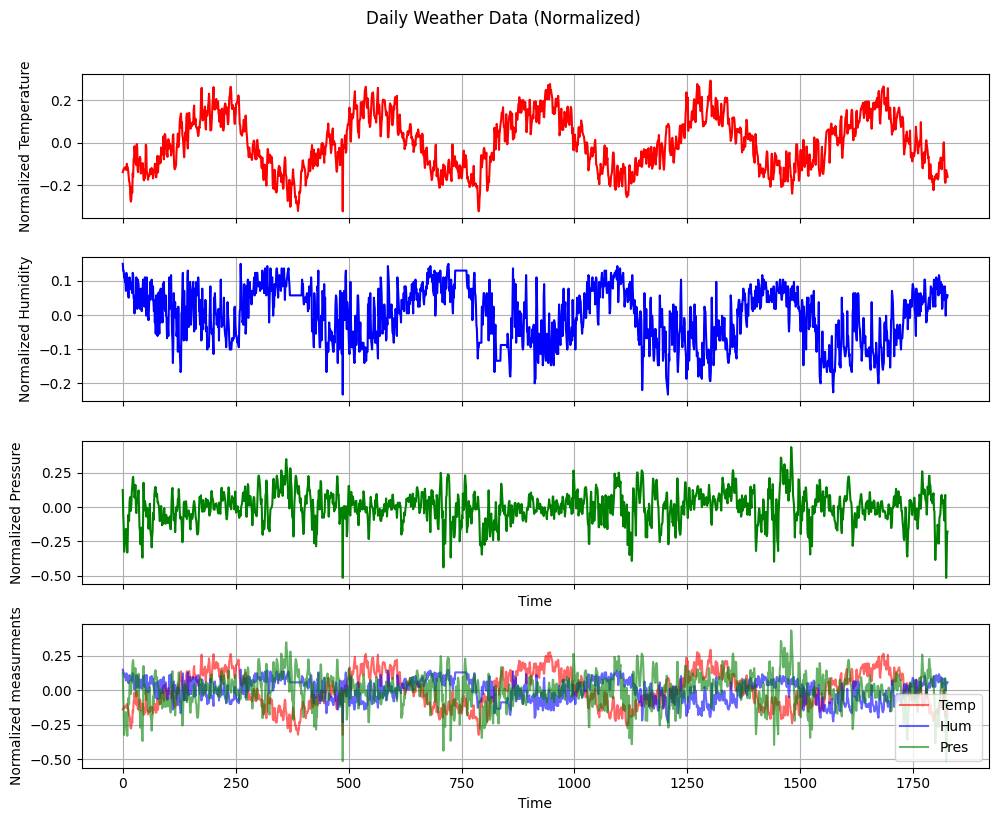

In [3]:
# row 1 in file : Time,Temperature,Humidity,Pressure
dailyweather = Data("dailyweather.csv",["Year","Temerature","Humidity","Pressure"],skiprows=1,delimiter=",")
#print(np.shape(dailyweather_raw))

T_plot,H_plot,P_plot = dailyweather.std_for_plot([1,2,3])

# Create figure with 3 vertical subplots
fig, (ax1, ax2, ax3, ax4) = plt.subplots(4, 1, figsize=(10, 8), sharex=True)

# Plot Temperature
ax1.plot(T_plot, color='red')
ax1.set_ylabel('Normalized Temperature')
ax1.grid(True)

# Plot Humidity
ax2.plot(H_plot, color='blue')
ax2.set_ylabel('Normalized Humidity')
ax2.grid(True)

# Plot Pressure
ax3.plot(P_plot, color='green')
ax3.set_ylabel('Normalized Pressure')
ax3.set_xlabel('Time')
ax3.grid(True)

# Plot Pressure
ax4.plot(T_plot, alpha=0.6, color='red', label="Temp")
ax4.plot(H_plot, alpha=0.6, color='blue', label="Hum")
ax4.plot(P_plot, alpha=0.6, color='green', label="Pres")
ax4.set_ylabel('Normalized measurments')
ax4.set_xlabel('Time')
ax4.legend()
ax4.grid(True)

# Main title
plt.suptitle('Daily Weather Data (Normalized)', y=1.02, fontsize=12)

# Adjust layout to prevent overlap
plt.tight_layout()
plt.show()

Visually there sems to be some correlation in between the humidity and temperature. They seem to have similar periodicity, but in oposite phase, althoug the Humidity visually has higher variance, ecpesially when temperature is high. The pressure does not look very correlated visually.

In [4]:
pairs, correlations = dailyweather.calc_correlations([1,2,3])

for i,pair in enumerate(pairs):
    print(f"Correlation betweem {dailyweather.elements[pair[0]]} and {dailyweather.elements[pair[1]]} = {correlations[i]}")


Correlation betweem Temerature and Humidity = -0.5482806470222328
Correlation betweem Temerature and Pressure = -0.02336909844159686
Correlation betweem Humidity and Pressure = 0.000829331040370216


The calculated correlation between Temp and Humidity confirms there is some correlation between them, the others seem to have little to no correlation.

/var/folders/pd/2bgmf1pd7fv79_2hltggtpsw0000gn/T/ipykernel_96265/1179199498.py:77: MatplotlibDeprecationWarning: Unable to determine Axes to steal space for Colorbar. Using gca(), but will raise in the future. Either provide the *cax* argument to use as the Axes for the Colorbar, provide the *ax* argument to steal space from it, or add *mappable* to an Axes.
  cbar = plt.colorbar(sm, label='Position along trajectory')


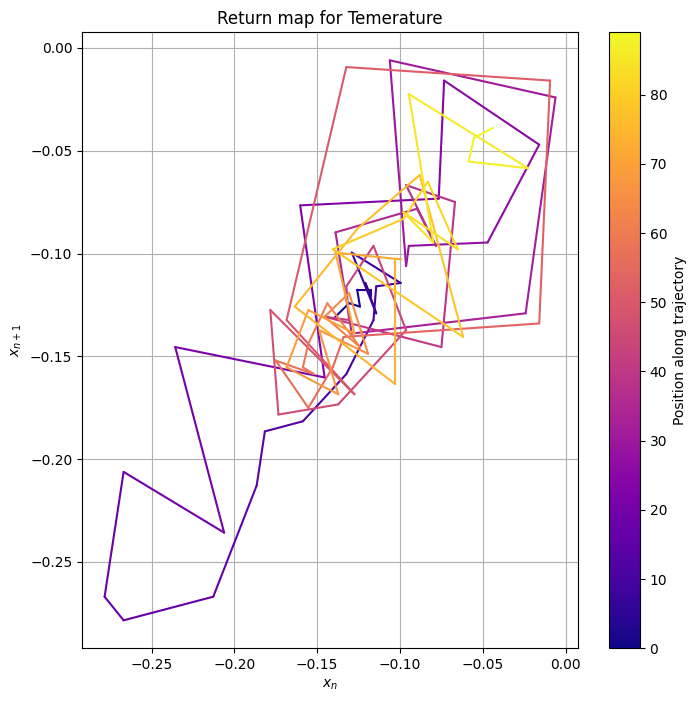

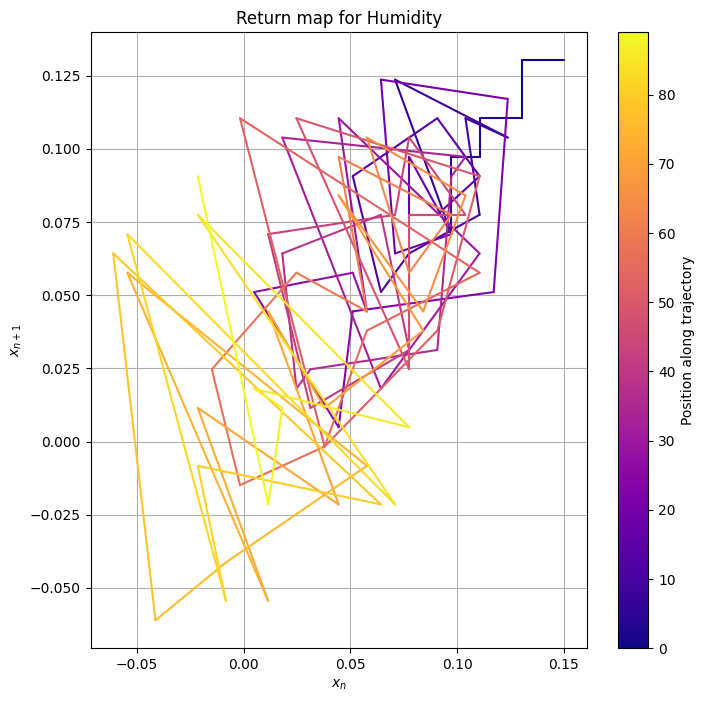

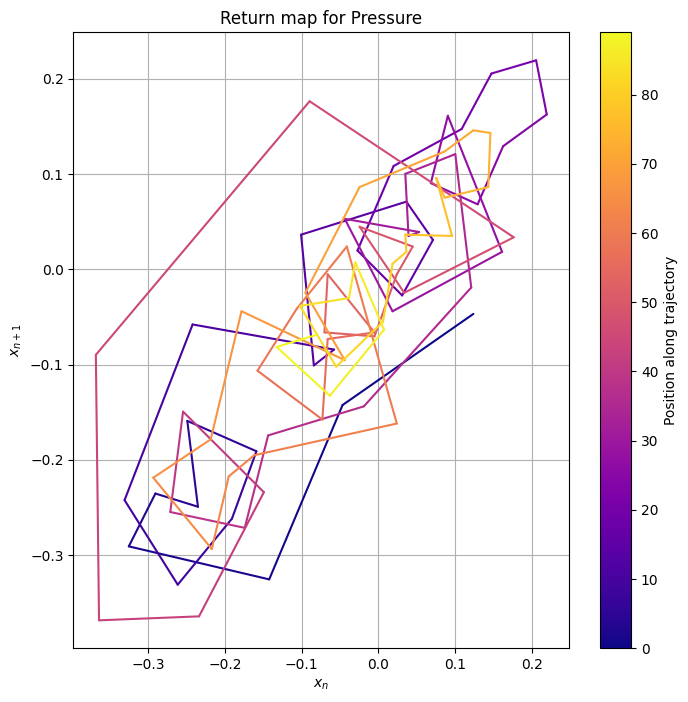

In [ ]:
for i in range(1,4):
    dailyweather.return_map(i,30,title=dailyweather.elements[i],cmap="plasma")